## Exploration of Chicago Ride Hailing Data

Data source: https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p

The data is from ride hailing apps like Uber and Lyft, and contains information on prices, trip locations, pooling options, etc as described on the data source page for around 17 million trips in Chicago in November & December of 2018

In [219]:
#imports
from security import get_credential

import requests
import pandas as pd
import matplotlib
%matplotlib inline

In [220]:
matplotlib.rcParams.update({'font.size': 15})

In [196]:
#set up client for API access of data (from data source doc)
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
# client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
client = Socrata('data.cityofchicago.org',
                 get_credential("CHICAGO_DATA_PORTAL_APP_TOKEN"),
                 username=get_credential("CHICAGO_DATA_PORTAL_USERNAME"),
                 password=get_credential("CHICAGO_DATA_PORTAL_PASSWORD"))

We restrict to non-pool trips, and trips that begin & end in Chicago. Also, for high-level stats we aggregate the number of trips by pickup community area and day-of-week.

In [51]:
query="select count(trip_id), pickup_community_area, date_extract_dow(trip_start_timestamp)\
where (trips_pooled=1) and (pickup_community_area is not null) \
and (dropoff_community_area is not null)\
group by pickup_community_area, date_extract_dow(trip_start_timestamp)"

results = client.get("m6dm-c72p", query=query)

In [211]:
df = pd.DataFrame.from_records(results)
df.head(3)

,count_trip_id,date_extract_dow_trip_start_timestamp,pickup_community_area
0,2943,0,70
1,10656,3,2
2,3880,3,10


In [212]:
#nice column names
df.rename(columns={"count_trip_id": "count", 
                   "date_extract_dow_trip_start_timestamp": "dow",
                  "pickup_community_area":"area"},inplace=True)
#string values to int
df = df.astype(int)

In [213]:
df.head(3)

,count,dow,area
0,2943,0,70
1,10656,3,2
2,3880,3,10


In [215]:
#index by area, row is timeseries
dfp = df.pivot(index='area',columns='dow',values='count')
dfp.head(3)

dow,0,1,2,3,4,5,6
area,,,,,,,
1,20749,14198,13826,14068,16848,19949,24072
2,12552,10868,10015,10656,12011,13395,13856
3,52928,32075,29012,32303,39027,47550,64647


In [216]:
#basic stats
dfp['avg'] = dfp.mean(axis=1)
dfp['std'] = dfp.std(axis=1)

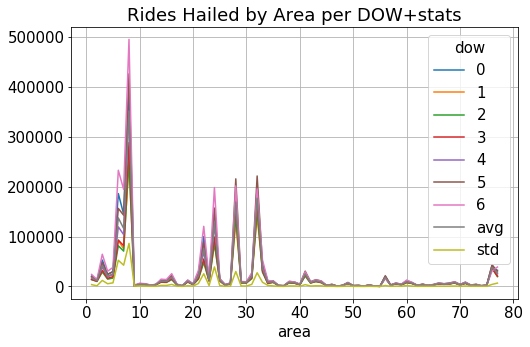

In [225]:
#0 is sunday
dfp.plot(figsize=(8,5),grid=True,title='Rides Hailed by Area per DOW+stats')

We observe a large variation in daily patterns over small number of areas, let's dive in on these areas with **large numbers of rides and variability**.

First, let's look at the top 10 areas with the largest standard deviation.

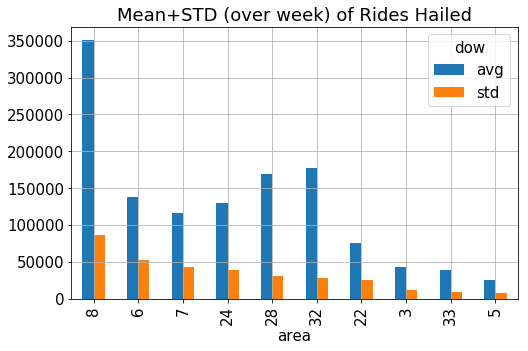

In [227]:
dfp.sort_values('std',ascending=False)[:10][['avg','std']]\
.plot.bar(figsize=(8,5),grid=True,title='Mean+STD (over week) of Rides Hailed')

For reference, map of community areas in Chicago

![](cca.png)

This makes sense, in and around central Chicago has the highest number of rides hailed.

Since we didn't normalize our distributions, we can be a bit more precise and look at the **coefficient of variation, or std/mean**, to see which community area has the highest variability of rides hailed.

In [233]:
#add c of v stat
dfp['cv'] = dfp['std']/dfp['avg']

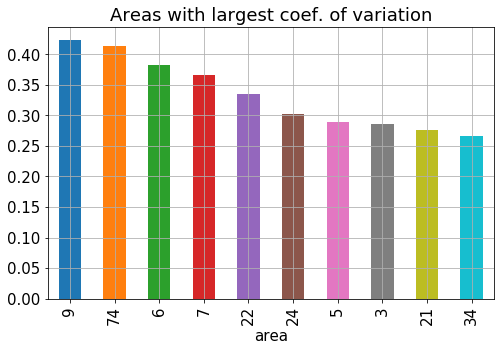

In [234]:
dfp.sort_values('cv',ascending=False)[:10]['cv']\
.plot.bar(figsize=(8,5),grid=True,title='Areas with largest coef. of variation')


Let's dive in on community area 6 since it has a high number of rides and high coefficient of variation. We can get **finer grained data** to examine the hourly counts of rides hailed.

In [197]:
query="select count(trip_id), date_extract_hh(trip_start_timestamp)\
where (trips_pooled=1) and (pickup_community_area=6) \
and (dropoff_community_area is not null)\
group by date_extract_hh(trip_start_timestamp)"

r2 = client.get("m6dm-c72p", query=query)

In [235]:
hdf = pd.DataFrame.from_records(r2)
hdf.rename(columns={"count_trip_id": "count", 
                   "date_extract_hh_trip_start_timestamp": "hour"},inplace=True)
hdf = hdf.astype(int)

In [237]:
hdf.head(3)

,count,hour
0,35698,2
1,28097,3
2,46817,1


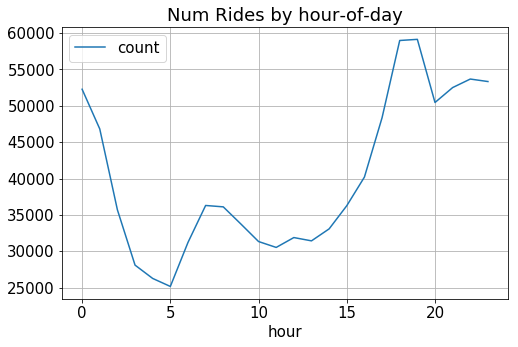

In [243]:
hdf.set_index('hour').sort_index().plot(figsize=(8,5),grid=True,title='Num Rides by hour-of-day')

This exhibits a large variation over a day, suggesting a predictive model could help to send drivers to certain areas at different times of the day.

## Most common destinations? Price Variation? Pool vs Non-pool? Outside Chicago?